# Code for developing and testing CondLowRankMatrixDistribution objects

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondLowRankMatrixDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

## Here we generate properites for neurons we simulate conditioning on and specify how many modes we are going to work with

In [3]:
# Properties of neurons we condition on 
n_neurons = 2000
neuron_props = torch.zeros(n_neurons, 2).uniform_()

n_modes = 2

## Here we define helper functions for visualizing distributions 

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
def visualize_low_rank_matrix_modes(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    l_dists = d.l_mode_dists
    r_dists = d.r_mode_dists
    
    n_modes = len(l_dists)
    
    plt.figure()
    
    for m_i in range(n_modes):
        
        # Plot r modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(r_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot l modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(l_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        

## Setup the true distribution

In [5]:
# Spike and slab modes

p_l_mode_dists = [None]*n_modes
p_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.2,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    p_l_spike_d = CondBernoulliDistribution(p_l_spike_log_prob_fcn)

    p_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                                        torch.nn.Linear(5,1))

    p_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    p_l_slab_d = CondGaussianDistribution(mn_f=p_l_slab_mn_fcn, std_f=p_l_slab_std_fcn)


    p_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_spike_d, slab_d=p_l_slab_d)
    
    
    # Setup r mode 
    p_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.2,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    p_r_spike_d = CondBernoulliDistribution(p_r_spike_log_prob_fcn)

    p_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                                        torch.nn.Linear(5,1))

    p_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    p_r_slab_d = CondGaussianDistribution(mn_f=p_r_slab_mn_fcn, std_f=p_r_slab_std_fcn)


    p_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_spike_d, slab_d=p_r_slab_d)
    

p = CondLowRankMatrixDistribution(l_mode_dists=p_l_mode_dists, r_mode_dists=p_r_mode_dists)

## Setup the inference distribution

In [6]:
class GeneralLogCondProb(torch.nn.Module):
    
    def __init__(self, n_nodes = 10):
        
        super().__init__()
        
        self.net = torch.nn.Sequential(torch.nn.Linear(2, n_nodes), torch.nn.Tanh(), torch.nn.Linear(n_nodes, n_nodes),
                                                 torch.nn.Tanh(), torch.nn.Linear(n_nodes, 1), torch.nn.LogSigmoid())
        
    def forward(self, x):
        return self.net(x).squeeze()

In [7]:
q_l_mode_dists = [None]*n_modes
q_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    
    
    # Setup l mode
    
    q_l_spike_log_prob_fcn = GeneralLogCondProb(10)
    
    q_l_spike_d = CondBernoulliDistribution(q_l_spike_log_prob_fcn)

    q_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                                        torch.nn.Linear(5,1))

    q_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    q_l_slab_d = CondGaussianDistribution(mn_f=q_l_slab_mn_fcn, std_f=q_l_slab_std_fcn)

    q_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_l_spike_d, slab_d=q_l_slab_d)

    
    # Setup r mode 

    q_r_spike_log_prob_fcn = GeneralLogCondProb(10)
    
    q_r_spike_d = CondBernoulliDistribution(q_r_spike_log_prob_fcn)

    q_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                                        torch.nn.Linear(5,1))

    q_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    q_r_slab_d = CondGaussianDistribution(mn_f=q_r_slab_mn_fcn, std_f=q_r_slab_std_fcn)


    q_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_r_spike_d, slab_d=q_r_slab_d)
    
q = CondLowRankMatrixDistribution(l_mode_dists=q_l_mode_dists, r_mode_dists=q_r_mode_dists)

## Fit the q distribution 

In [12]:
n_its = 10000
update_int = 100

r_params = q.r_params()
s_params = q.s_params()

r_optim = torch.optim.Adam(r_params)
s_optim = torch.optim.Adam(s_params)

if len(r_params) > 0:
    r_optim = torch.optim.Adam(r_params)
    run_r_opt = True
else:
    run_r_opt = False
    
if len(s_params) > 0:
    s_optim = torch.optim.Adam(s_params)
    run_s_opt = True
else:
    run_s_opt = False
    
for i in range(n_its):
    # Don't need to calculate gradients for s_params yet
    for s_p in s_params:
        s_p.requires_grad = False
    
    # Sample q
    s_l_i, s_r_i = q.sample(neuron_props, neuron_props)
    
    # Compute the learning signal 
    q_l_ll, q_r_ll = q.log_prob(neuron_props, neuron_props, s_l_i, s_r_i)
    p_l_ll, p_r_ll = p.log_prob(neuron_props, neuron_props, s_l_i, s_r_i)
    kl_l = q_l_ll - p_l_ll
    kl_r = q_r_ll - p_r_ll
    
    # Calculate gradients for anthing we can use the reparameterization trick on
    if run_r_opt:
        r_optim.zero_grad()
        o_r = torch.sum(kl_l) + torch.sum(kl_r)
        o_r.backward(retain_graph=run_s_opt)
    else:
        o_r = torch.zeros(1)
    
    # Now set things up so we will calculate gradients of s_params next
    for s_p in s_params:
        s_p.requires_grad = True
        
    # Calculate gradients for anything we can't use the reparameterization trick on
    if run_s_opt:
        for r_p in r_params:
            r_p.requires_grad = False
    
        # Detach the learning signal since we don't want to run gradients through it
        with torch.no_grad():
            ls_l = kl_l
            ls_r = kl_r
            
        # Compute the objective for the score function and take a step - for each mode we only include terms
        # in the learning signal that are relevant for that mode 
        s_optim.zero_grad()
        o_s =0
        for m_i in range(n_modes):       
            o_s += torch.sum(ls_l[:,m_i]*q.l_mode_dists[m_i].log_prob(neuron_props, s_l_i[m_i]))
            o_s += torch.sum(ls_r[:,m_i]*q.r_mode_dists[m_i].log_prob(neuron_props, s_r_i[m_i]))

        o_s.backward()
         
        for r_p in r_params:
            r_p.requires_grad = True
    else:
        o_s = torch.zeros(1)

        
    # Take steps for both r and s parameters now 
    if run_r_opt:
        r_optim.step()
    if run_s_opt:
        s_optim.step()
        
    # Enforce constraints
    #enforce_constraints()
 
    # Provide some feedback
    o_r_record = np.float(o_r.detach().numpy())
    o_s_record = np.float(o_s.detach().numpy())
    if i % update_int == 0:
        print('it: ' + str(i) + ', o_r: ' + str(o_r_record) + ', o_s: ' + str(o_s_record))

it: 0, o_r: 840.6097412109375, o_s: 39.489933013916016
it: 100, o_r: 837.3482666015625, o_s: 57.20962905883789
it: 200, o_r: 834.7932739257812, o_s: 72.854736328125
it: 300, o_r: 849.8104248046875, o_s: -29.05547523498535
it: 400, o_r: 876.7342529296875, o_s: -196.55020141601562
it: 500, o_r: 861.89111328125, o_s: -91.44598388671875
it: 600, o_r: 824.849853515625, o_s: 97.26272583007812
it: 700, o_r: 838.87939453125, o_s: 31.975929260253906
it: 800, o_r: 848.3392333984375, o_s: -4.920658111572266
it: 900, o_r: 842.3275146484375, o_s: 8.743538856506348
it: 1000, o_r: 832.0780029296875, o_s: 85.27920532226562
it: 1100, o_r: 833.069580078125, o_s: 77.59375
it: 1200, o_r: 844.8772583007812, o_s: 9.757343292236328
it: 1300, o_r: 867.734619140625, o_s: -142.18951416015625
it: 1400, o_r: 863.5429077148438, o_s: -92.99346923828125
it: 1500, o_r: 835.1534423828125, o_s: 80.2605209350586
it: 1600, o_r: 841.9962768554688, o_s: 31.99797821044922
it: 1700, o_r: 851.681640625, o_s: -29.0036354064941

## Visualize true and fit distribution

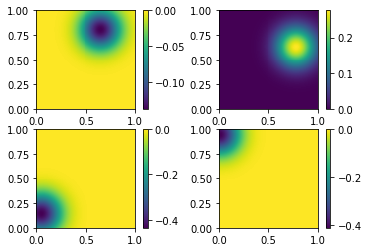

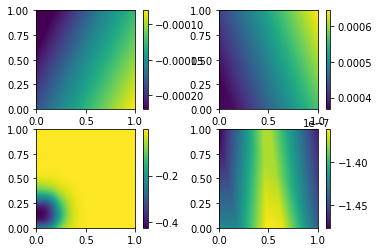

In [13]:
visualize_low_rank_matrix_modes(p)
visualize_low_rank_matrix_modes(q)

In [ ]:
a = torch.zeros(1)

In [ ]:
a.squeeze().shape